## Importing libraries

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

## Loading Dataset

In [10]:
df = pd.read_csv('/Users/praveesha/Desktop/IS733/lab/Lab5/spam_dataset.csv')

## Naive Bayes

In [13]:
# Separate features and target
X_text = df['Content']  # Mail content
X_numeric = df[['win', 'click', 'team', 'claim', 'reminder']]  # Other features
y = df['Category']  # Target variable (Spam, Ham)

# Convert the category to numerical labels (Spam=1, Ham=0)
y = y.map({'Spam': 1, 'Ham': 0})

# Split the data into training and testing sets
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42)

# Create a TfidfVectorizer to transform the 'content' column
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Vectorize the training and test data (content)
X_train_text_tfidf = vectorizer.fit_transform(X_train_text)
X_test_text_tfidf = vectorizer.transform(X_test_text)

# Concatenate the numerical features with the text features
from scipy.sparse import hstack
X_train = hstack([X_train_text_tfidf, X_train_num])
X_test = hstack([X_test_text_tfidf, X_test_num])

# Train a Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predict on the test set
y_pred = nb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Detailed classification report
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


Accuracy: 66.67%
              precision    recall  f1-score   support

         Ham       0.50      1.00      0.67         1
        Spam       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



### Improved model - Naive Bayes

##### Minmax Scaler
##### Bi-grams in text data
##### Tuning TfidfVectorizer Parameters

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Separate features and target
X_text = df['Content']
X_numeric = df[['win', 'click', 'team', 'claim', 'reminder']]
y = df['Category']

# Convert the category to numerical labels (Spam=1, Ham=0)
y = y.map({'Spam': 1, 'Ham': 0})

# Train-test split
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42)

# Create a TfidfVectorizer with optimized parameters
vectorizer = TfidfVectorizer(stop_words='english', max_features=1500, ngram_range=(1, 2), min_df=2)

# Normalize numeric features using MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to numeric data
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Vectorize the text data
X_train_text_tfidf = vectorizer.fit_transform(X_train_text)
X_test_text_tfidf = vectorizer.transform(X_test_text)

# Combine the text and numeric features
from scipy.sparse import hstack
X_train = hstack([X_train_text_tfidf, X_train_num_scaled])
X_test = hstack([X_test_text_tfidf, X_test_num_scaled])

# Use ComplementNB for better handling of imbalanced data
nb = ComplementNB()

# Train the model
nb.fit(X_train, y_train)

# Predict on the test set
y_pred = nb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Detailed classification report
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


Accuracy: 100.00%
              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00         1
        Spam       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



## KNN Classifier

In [24]:
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


# Separate features and target
X_text = df['Content']
X_numeric = df[['win', 'click', 'team', 'claim', 'reminder']]
y = df['Category']

# Convert category to numerical labels (Spam=1, Ham=0)
y = y.map({'Spam': 1, 'Ham': 0})

# Vectorize the text content using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_text_tfidf = vectorizer.fit_transform(X_text)

# Scale the numeric features using MinMaxScaler
scaler = MinMaxScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Concatenate text features with numeric features
X = hstack([X_text_tfidf, X_numeric_scaled])

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Use Leave-One-Out Cross-Validation (LOO-CV)
loo = LeaveOneOut()

# Define the parameter grid to search for optimal k
param_grid = {'n_neighbors': range(1, 15)}  # Given 15 instances, k can range from 1 to 14

# Set up GridSearchCV to search for the best k using LOO-CV
grid_search = GridSearchCV(knn, param_grid, cv=loo, scoring='accuracy')

# Train the model with GridSearchCV
grid_search.fit(X, y)

# Get the best k value
best_k = grid_search.best_params_['n_neighbors']
print(f'Optimal k with Leave-One-Out CV: {best_k}')

# Train the KNN classifier with the optimal k
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X, y)

# Since LOO-CV doesn't leave a test set, this is the best overall model for your data
print(f'Model trained with optimal k: {best_k}')


# Train the KNN classifier with the optimal k
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_best.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy with optimal k: {accuracy * 100:.2f}%')



Optimal k with Leave-One-Out CV: 3
Model trained with optimal k: 3
Accuracy with optimal k: 100.00%


## Decision Tree Classifier
#### ROC curve
#### AUC score

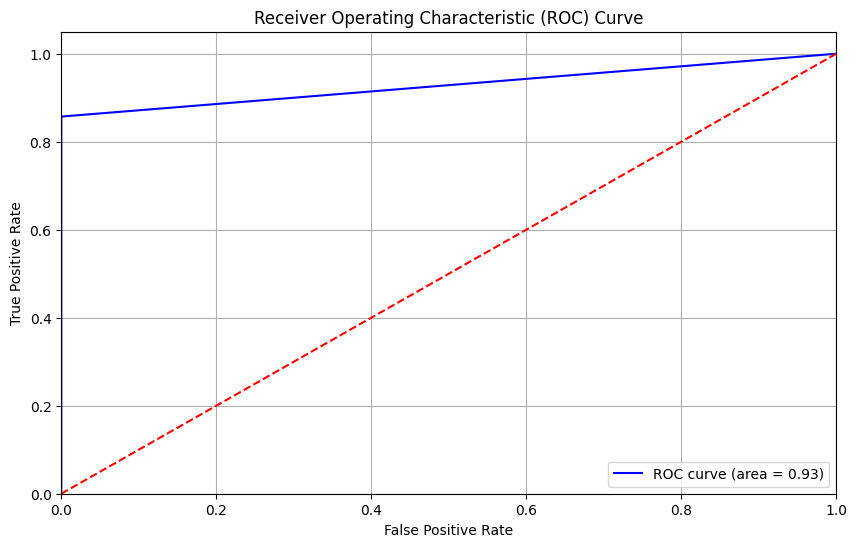

AUC Score: 0.93
Accuracy: 93.33%
              precision    recall  f1-score   support

         Ham       0.89      1.00      0.94         8
        Spam       1.00      0.86      0.92         7

    accuracy                           0.93        15
   macro avg       0.94      0.93      0.93        15
weighted avg       0.94      0.93      0.93        15



In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt
from scipy.sparse import hstack

# Separate features and target
X_text = df['Content']  # Mail content
X_numeric = df[['win', 'click', 'team', 'claim', 'reminder']]  # Other features
y = df['Category'].map({'Spam': 1, 'Ham': 0})  # Convert to numerical labels

# Vectorize the text content using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_text_tfidf = vectorizer.fit_transform(X_text)

# Scale the numeric features using MinMaxScaler
scaler = MinMaxScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combine text and numeric features
X = hstack([X_text_tfidf, X_numeric_scaled])

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Perform cross-validation and predict probabilities for ROC curve
y_scores = cross_val_predict(dt_classifier, X, y, cv=5, method='predict_proba')[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print AUC score
print(f'AUC Score: {roc_auc:.2f}')

# Optionally print accuracy and classification report
y_pred = (y_scores >= 0.5).astype(int)
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y, y_pred, target_names=['Ham', 'Spam']))
